### LOB Simulation Test with Advanced Stochastic Processes

In [1]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import torch

from copy import deepcopy
from datetime import datetime

from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.gym.helpers.visualize_return import *
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import *

In [2]:
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.rewards.RewardFunctions import CjMmCriterion

seed = np.random.randint(0, 10000000)
print("Seed in this run: ", seed)

max_inventory = 100

Seed in this run:  6684385


## Examine Avellanda-Stoikov Model

In [3]:
def get_as_env(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    sigma = 2.0 # CALIBRATEABLE, GBM volatility
    # GBM drift is 0 in this case
    n_steps = 4000
    initial_inventory = 0
    arrival_rate = 700 # CALIBRATEABLE, Poisson arrival rate for MO
    fill_exponent = 1.5 # CALIBRATEABLE, Exponential fill function exponent
    midprice_model = BrownianMotionMidpriceModel(initial_price = initial_price, drift=0.2,
                                                 volatility=sigma, step_size=1/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    # fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
    #                                                  step_size=1/n_steps,
    #                                                  num_trajectories=num_trajectories)
    fill_probability_model = CustomPowerFillFunction(fill_exponent=1.7348,
                                                fill_multiplier=0.1377,
                                                step_size=1/n_steps,
                                                num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

../mbt_gym/agents/BaselineAgents.py:78: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


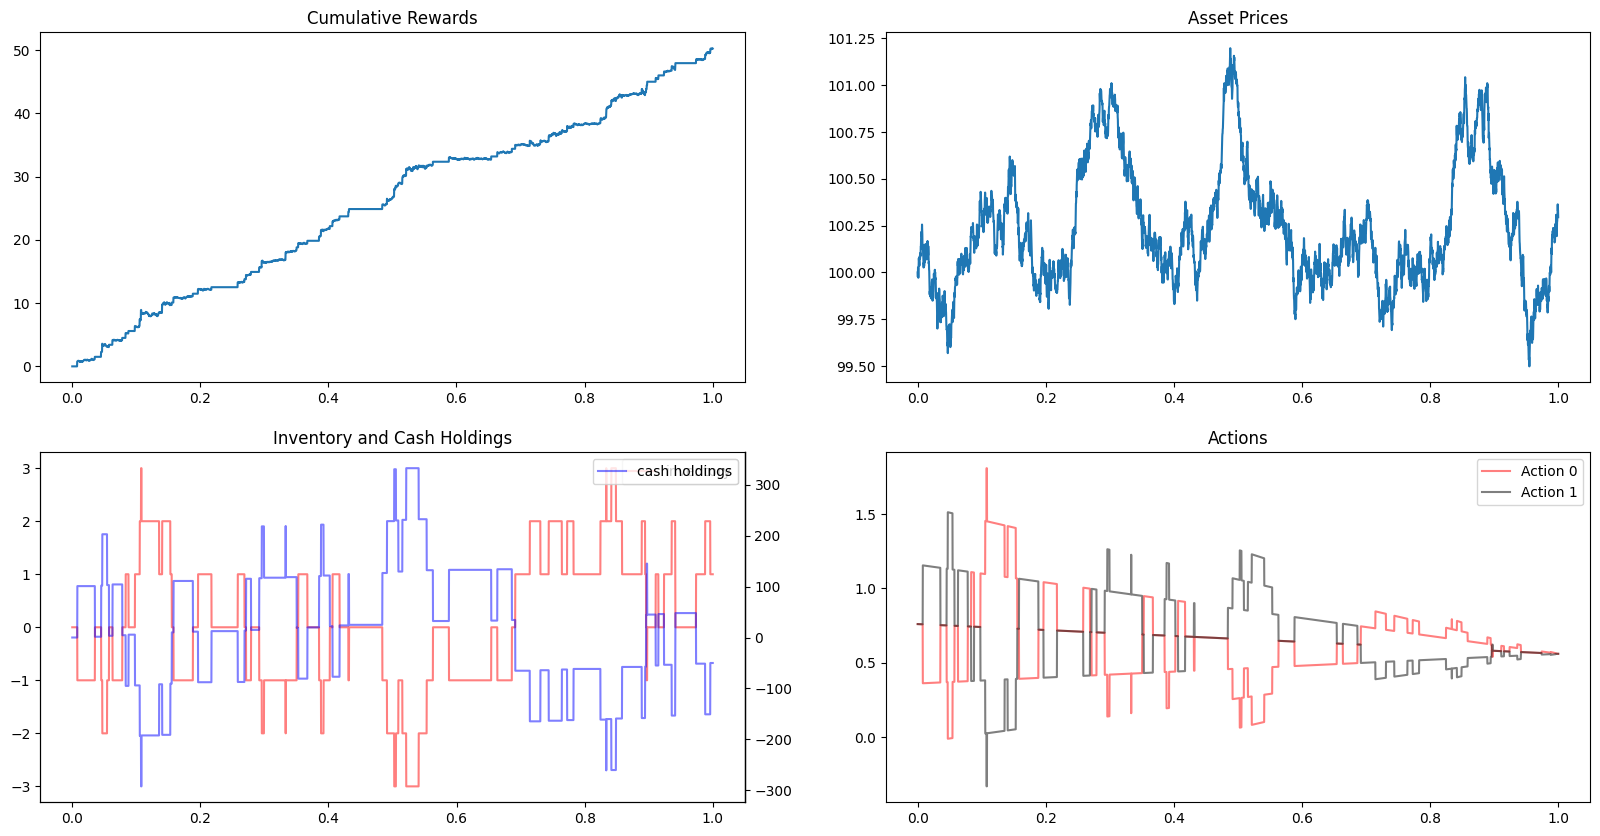

The number of unique actions taken in the first trajectory:  6835


In [4]:
as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

as_mid_series_1, as_action1 = plot_trajectory(as_env, as_agent, seed = seed)

# Ecamine how many counts of unique actions we have
as_action1 = as_action1.flatten()
unique, counts = np.unique(as_action1, return_counts=True)
as_action1_d = dict(zip(unique, counts))

print("The number of unique actions taken in the first trajectory: ", len(as_action1_d))


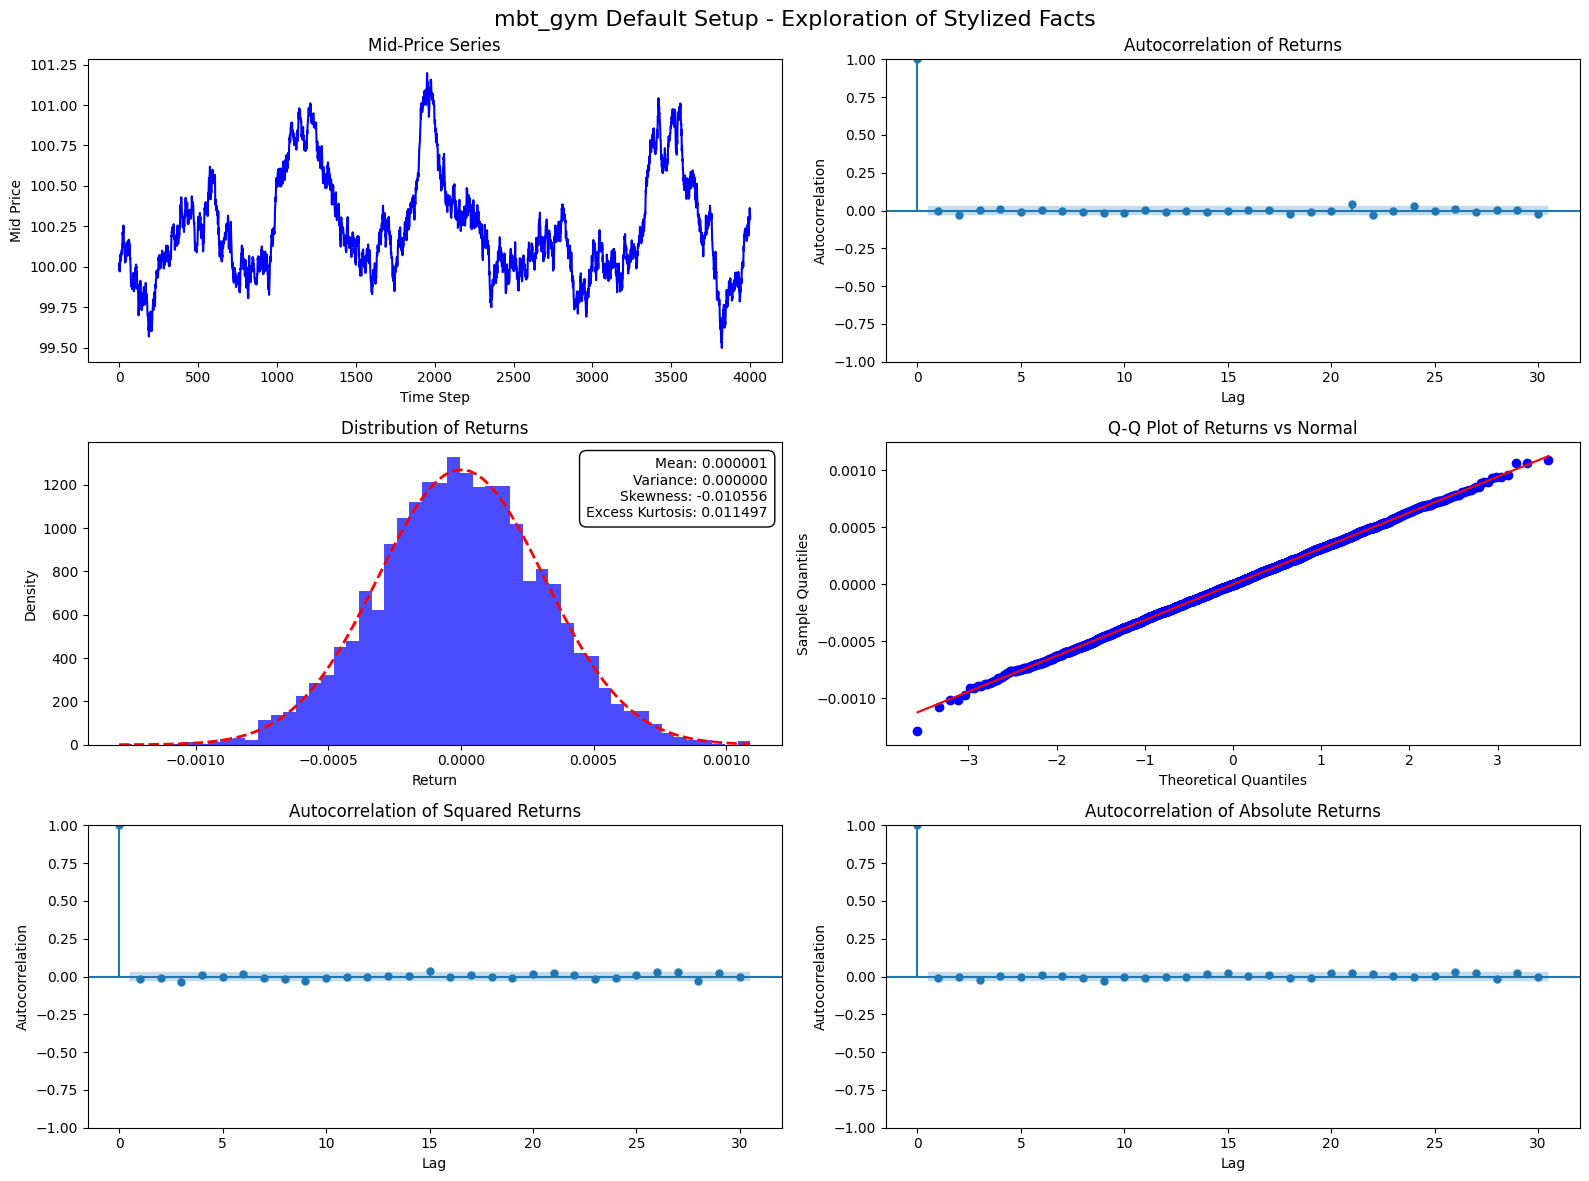

In [5]:
visualize_return(as_mid_series_1, "mbt_gym Default Setup - Exploration of Stylized Facts")

## Same setup, with CJ agent

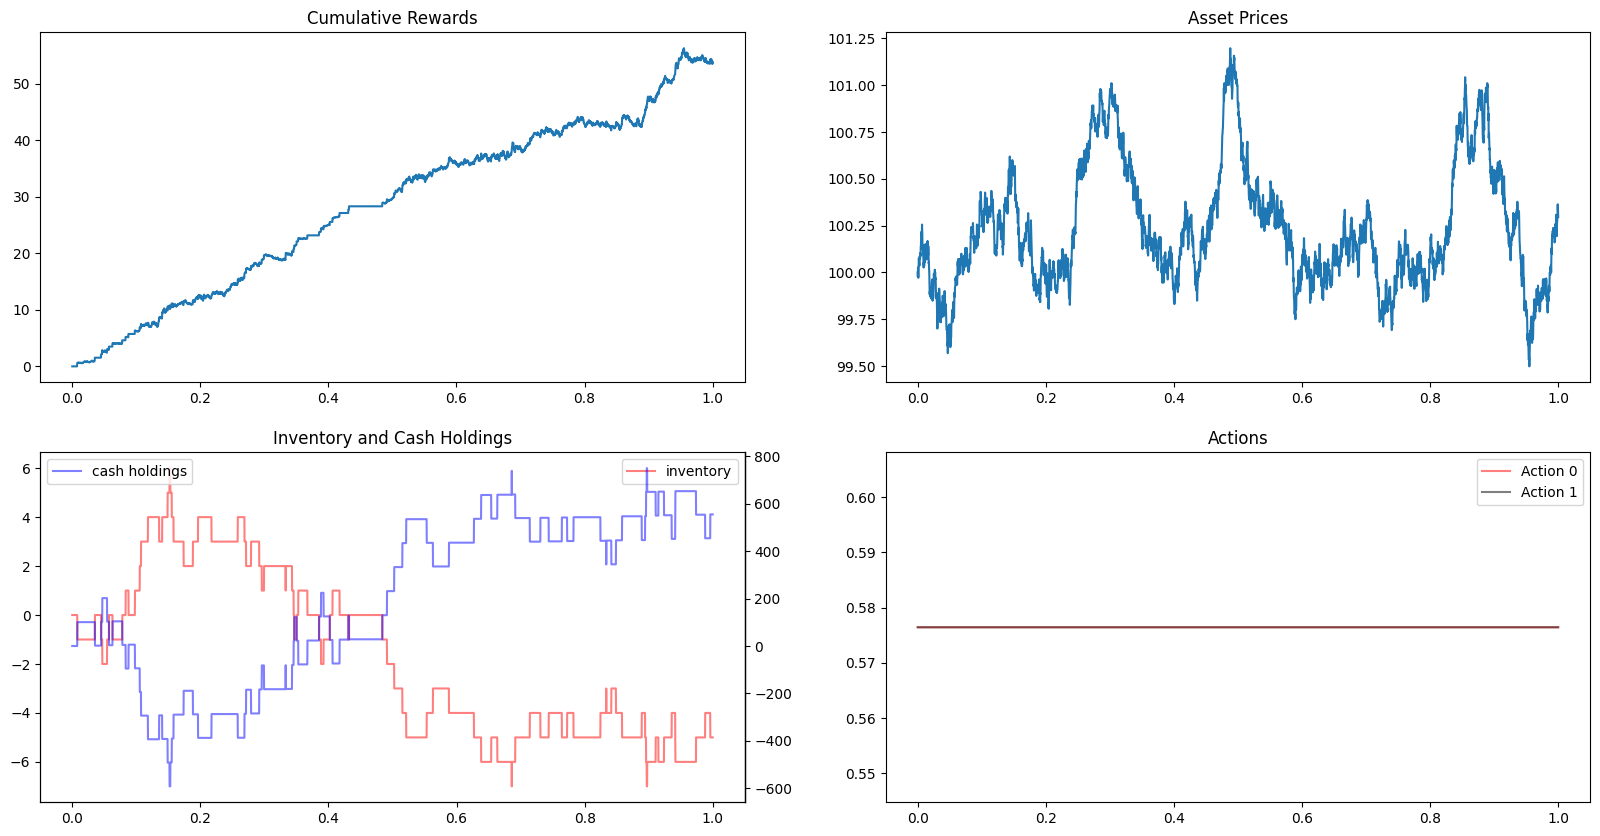

The number of unique actions taken in the first trajectory:  1


In [6]:
as_env = get_as_env()
as_agent = CarteaJaimungalMmAgent(env=as_env)

cj_mid_series_1, cj_action1 = plot_trajectory(as_env, as_agent, seed = seed)

# Examine how many counts of unique actions we have
cj_action1 = cj_action1.flatten()
unique, counts = np.unique(cj_action1, return_counts=True)
cj_action1_d = dict(zip(unique, counts))
print("The number of unique actions taken in the first trajectory: ", len(cj_action1_d))

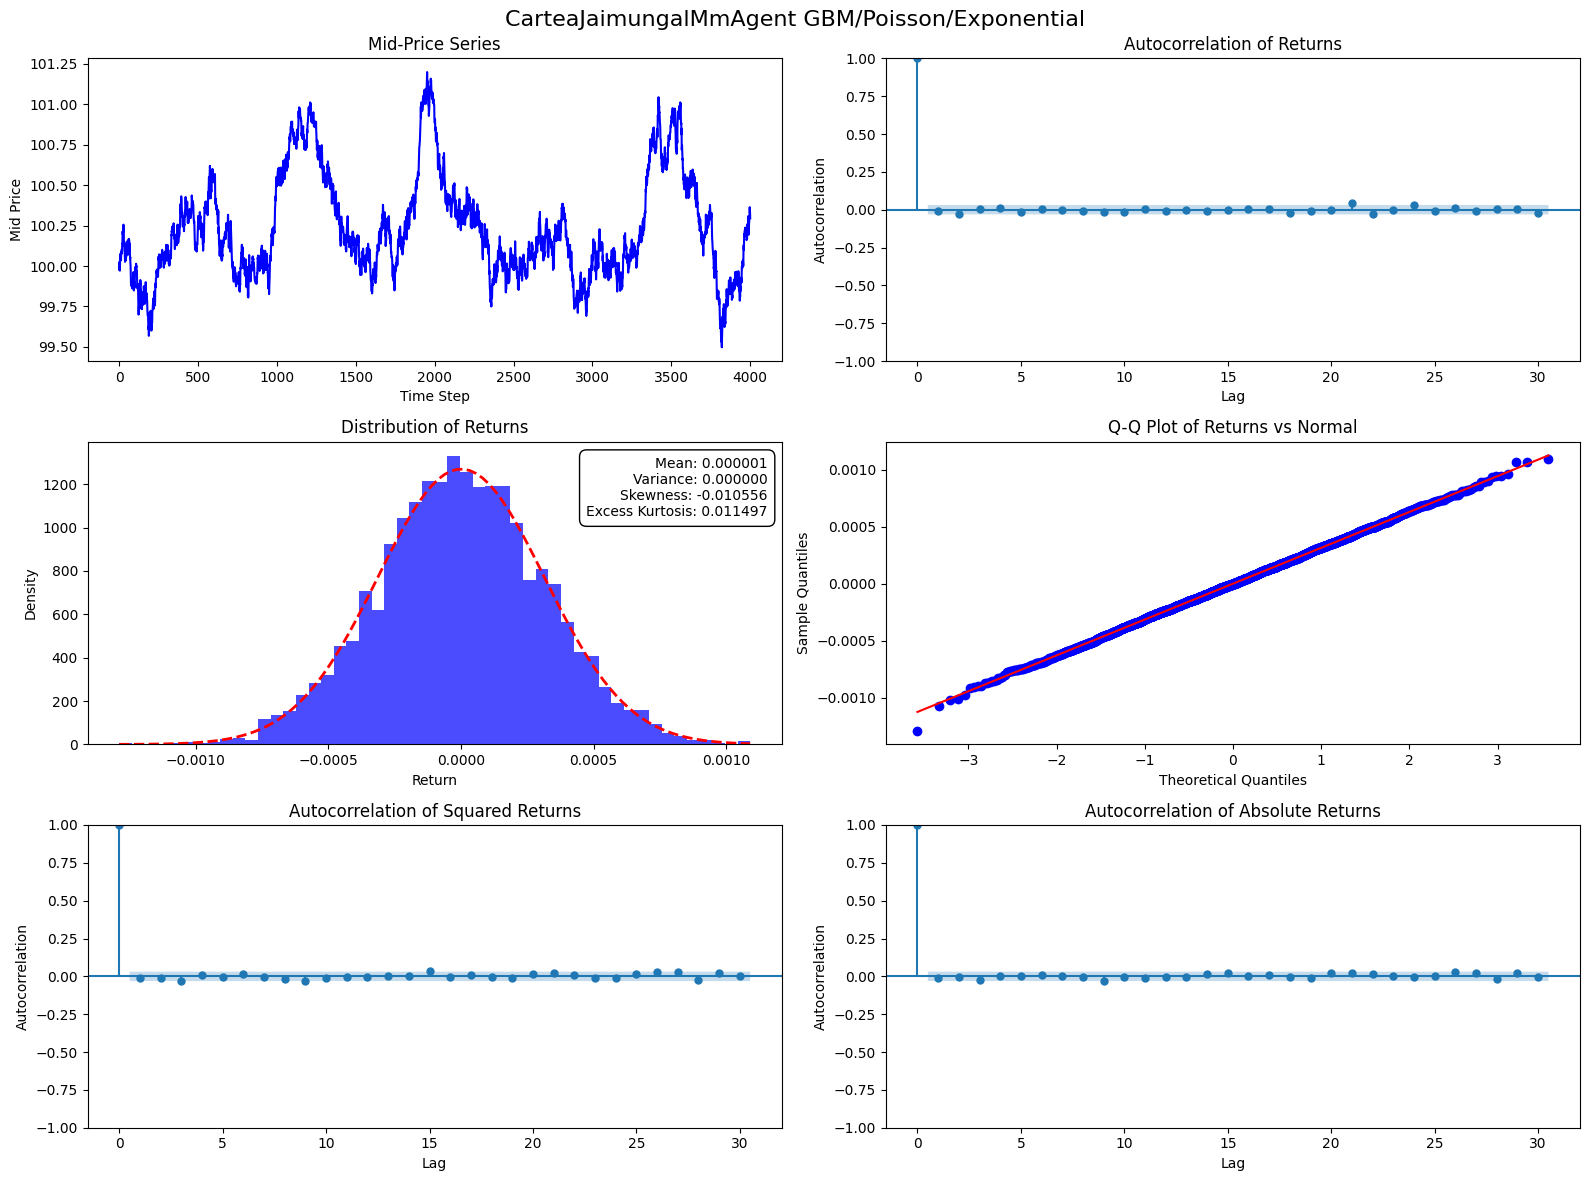

In [7]:
visualize_return(cj_mid_series_1, "CarteaJaimungalMmAgent GBM/Poisson/Exponential")

## Tweak vanilla Avelland Stoikov Model processes

In [8]:
def get_as_env_updated(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    sigma = 2.0 # CALIBRATEABLE, GBM volatility
    # GBM drift is 0 in this case, CALIBRATEABLE
    n_steps = 4000
    initial_inventory = 0
    arrival_rate = 700 # CALIBRATEABLE, Poisson arrival rate for MO
    fill_exponent = 1.5 # CALIBRATEABLE, Exponential fill function exponent
    midprice_model = BrownianMotionMidpriceModel(initial_price = initial_price, drift=0.2,
                                                 volatility=sigma, step_size=1/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = HawkesArrivalModel(step_size=1/n_steps, 
                                       num_trajectories=num_trajectories)
    fill_probability_model = PowerFillFunction(step_size=1/n_steps,
                                               num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

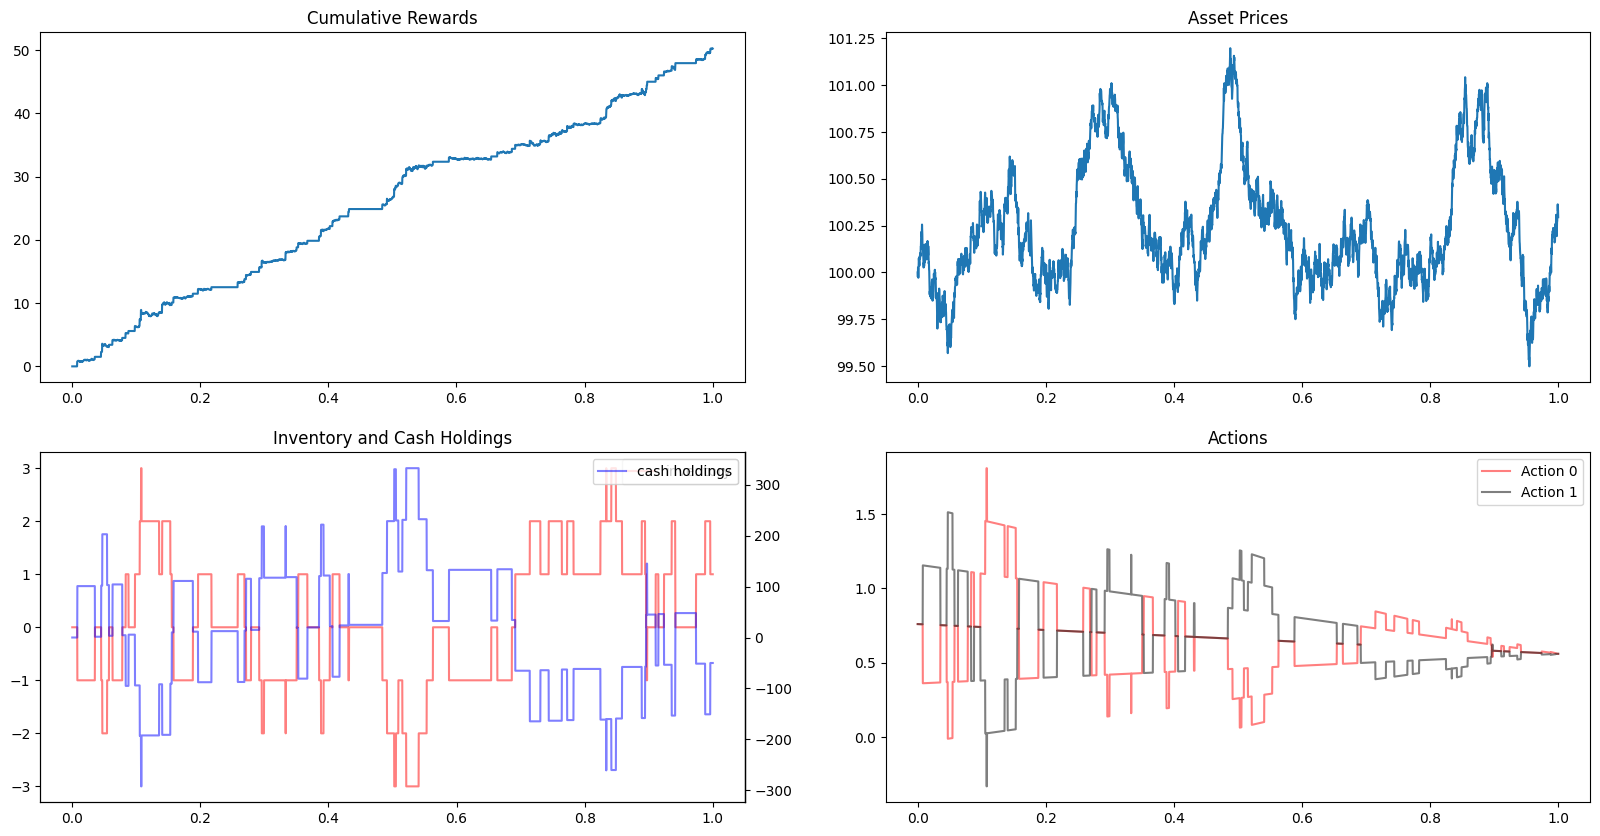

In [9]:
as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

as_mid_series_2, _ = plot_trajectory(as_env, as_agent, seed = seed)

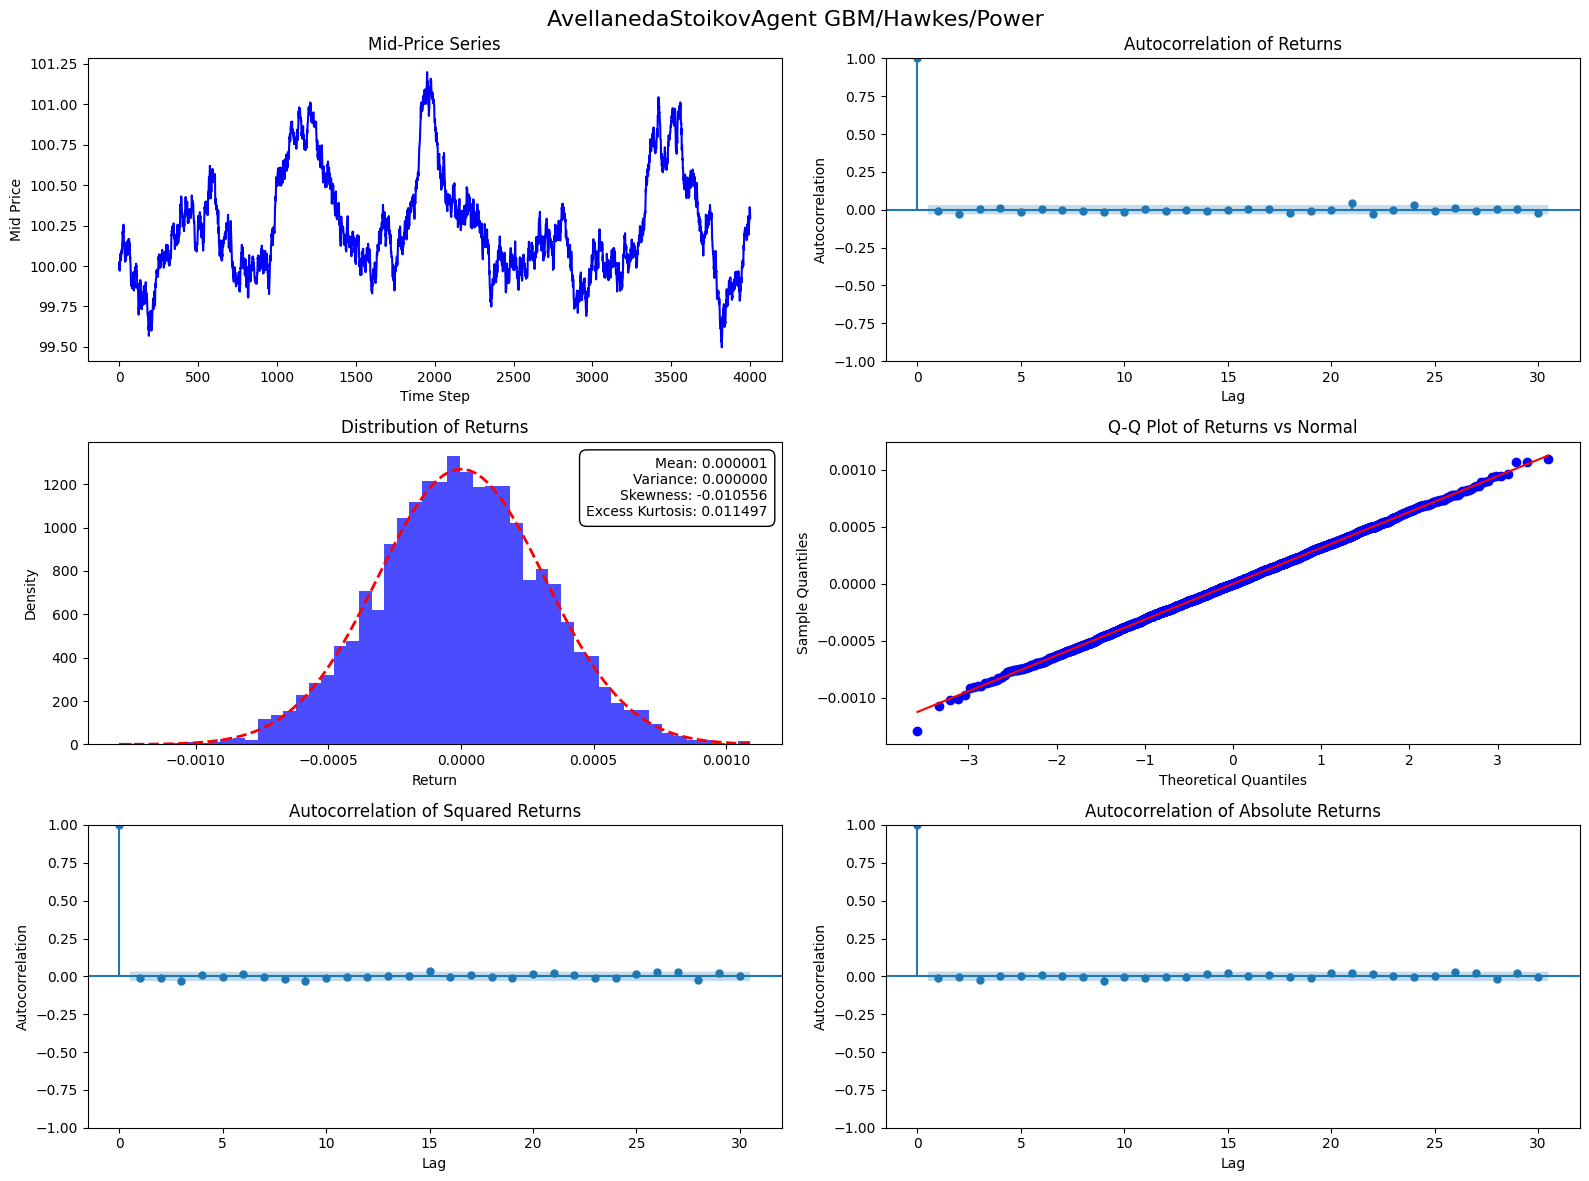

In [10]:
visualize_return(as_mid_series_2, "AvellanedaStoikovAgent GBM/Hawkes/Power")

Conclusions: When we changed the arrival process from Poisson to Hawkes, and the fill function from Exponential to Power, the mid-price and return characteristics don't change as long as we are using the same seed. This shows that mid-price process (at least GBM) is decoupled from arrival models and fill probability functions, which makes it unable to model price impact and is somewhat unrealistic.

## Experimenting with Price Impact Model

In [11]:
def get_as_env_priceImpact1(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    sigma = 2.0 # CALIBRATEABLE, GBM volatility
    # GBM drift is 0 in this case
    n_steps = 4000
    initial_inventory = 0
    arrival_rate = 700 # CALIBRATEABLE, Poisson arrival rate for MO
    fill_exponent = 1.5 # CALIBRATEABLE, Exponential fill function exponent
    midprice_model = BrownianMotionJumpMidpriceModel(initial_price = initial_price, jump_size=1.0, drift=0.2,
                                                 volatility=sigma, step_size=terminal_time/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

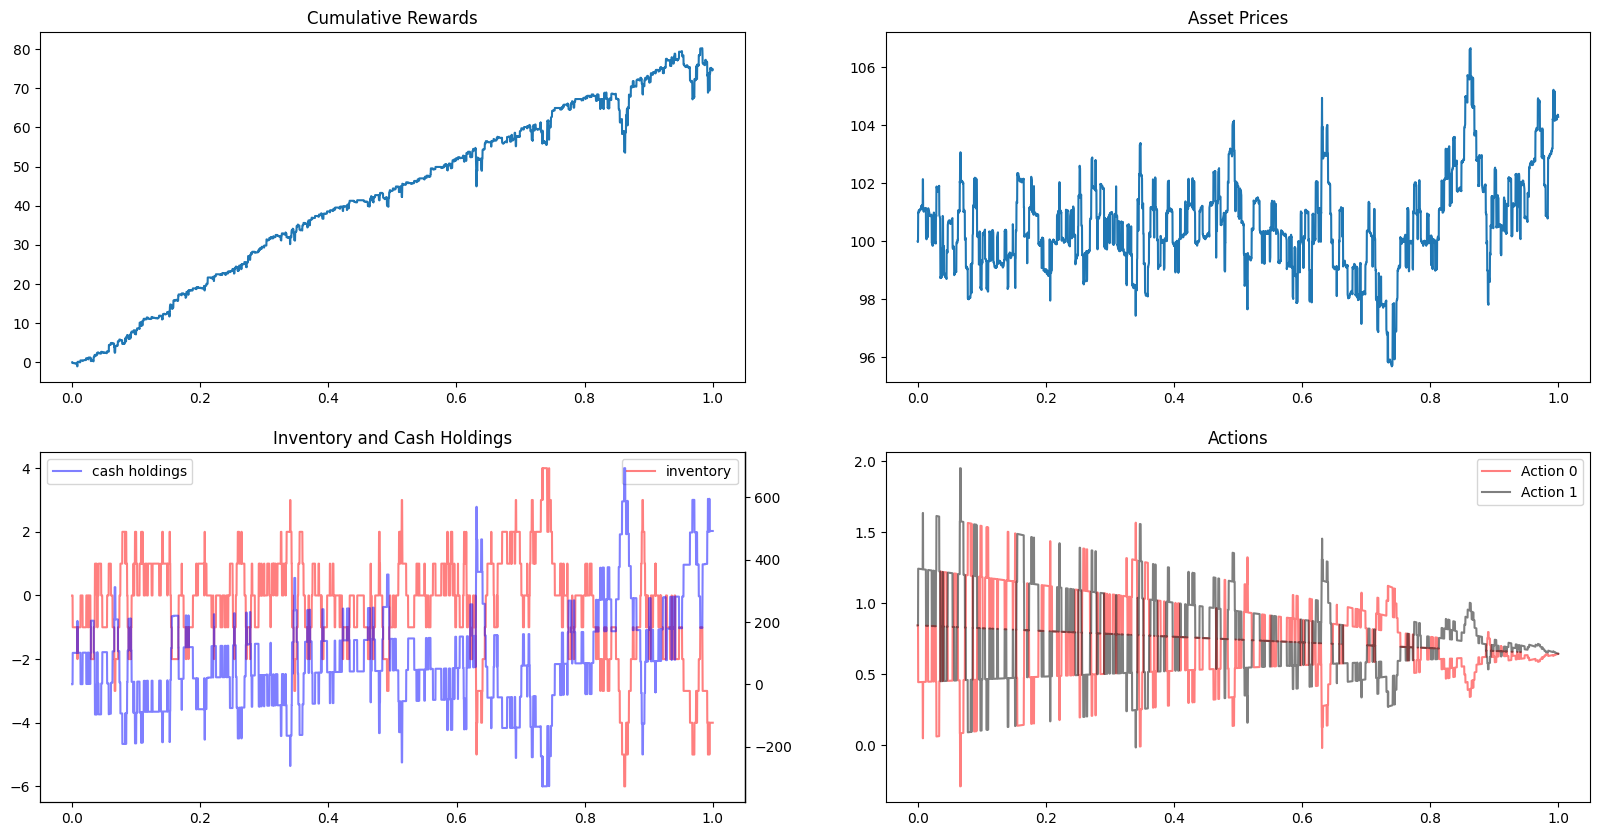

In [12]:
as_env = get_as_env_priceImpact1()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

as_mid_series_3, _ = plot_trajectory(as_env, as_agent, seed = seed)

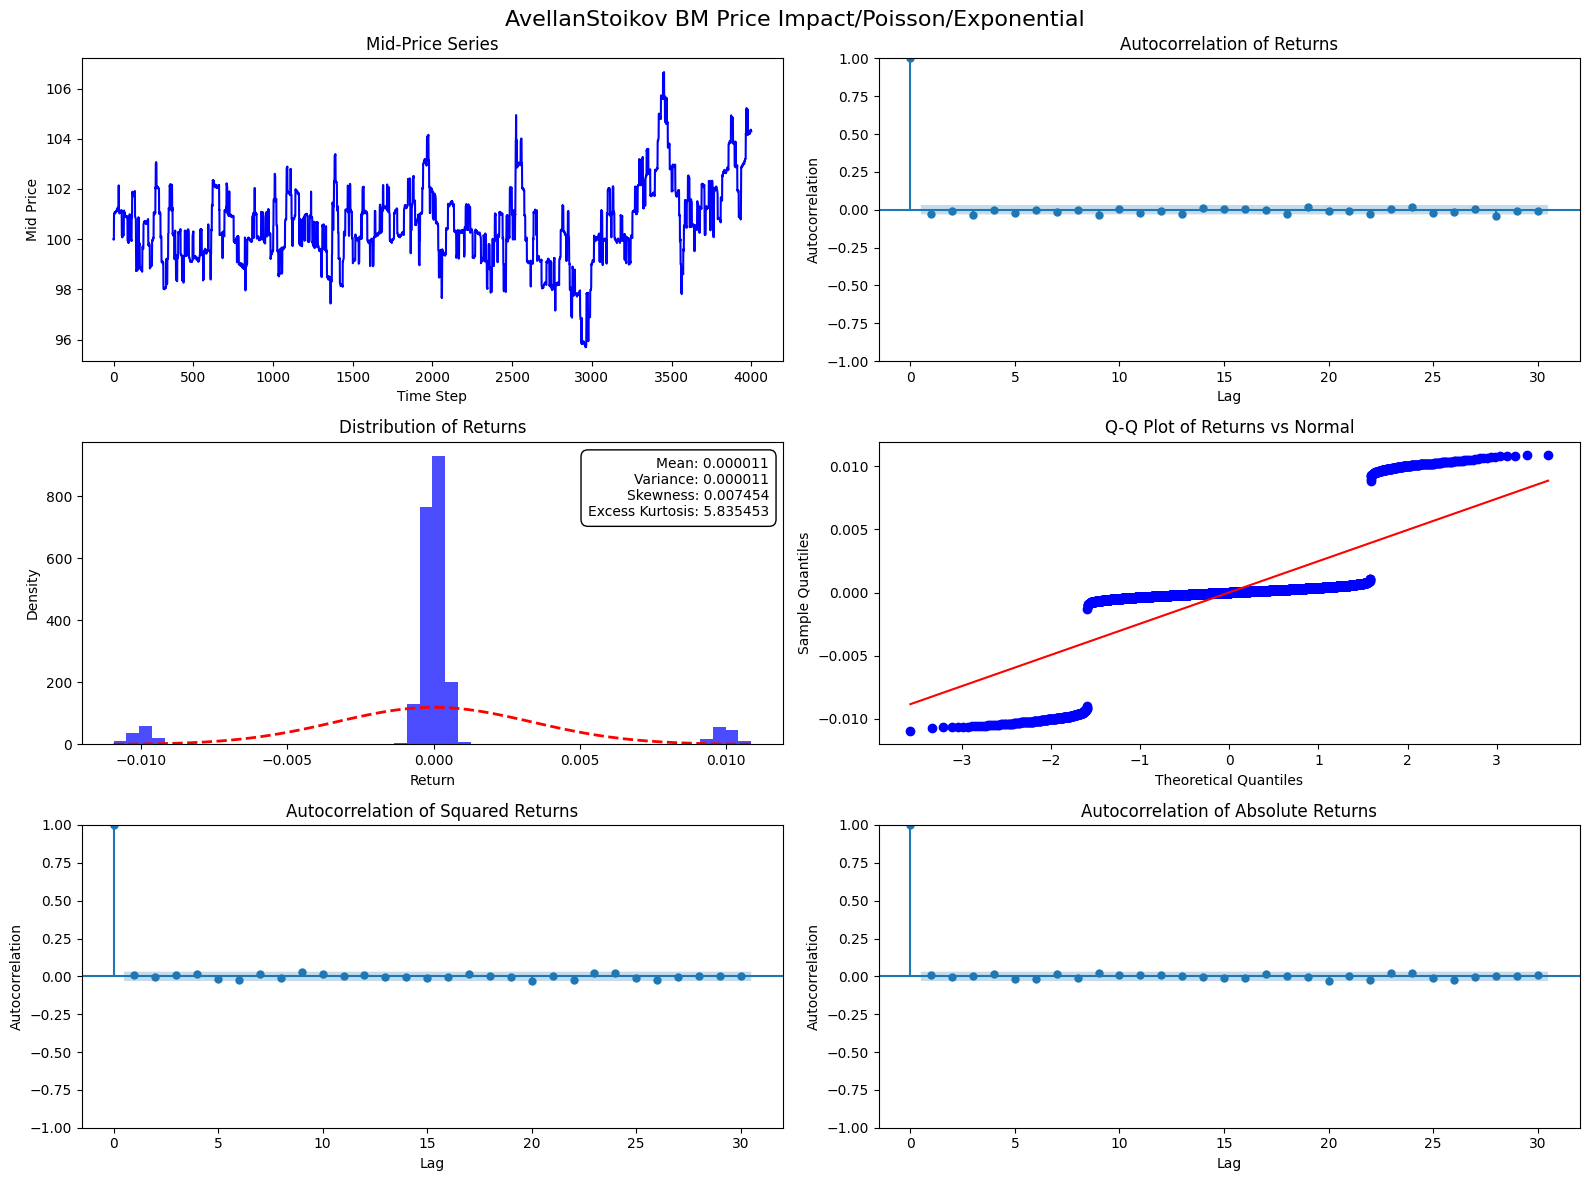

In [13]:
visualize_return(as_mid_series_3, "AvellanStoikov BM Price Impact/Poisson/Exponential")

In [14]:
def get_as_env_priceImpact3(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    sigma = 10.0 # CALIBRATEABLE, GBM volatility
    # GBM drift is 0 in this case
    n_steps = 4000
    initial_inventory = 0
    arrival_rate = 700 # CALIBRATEABLE, Poisson arrival rate for MO
    fill_exponent = 1.5 # CALIBRATEABLE, Exponential fill function exponent
    midprice_model = BrownianMotionJumpMidpriceModel(initial_price = initial_price, jump_size=1.0, drift=0.2,
                                                 volatility=sigma, step_size=terminal_time/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

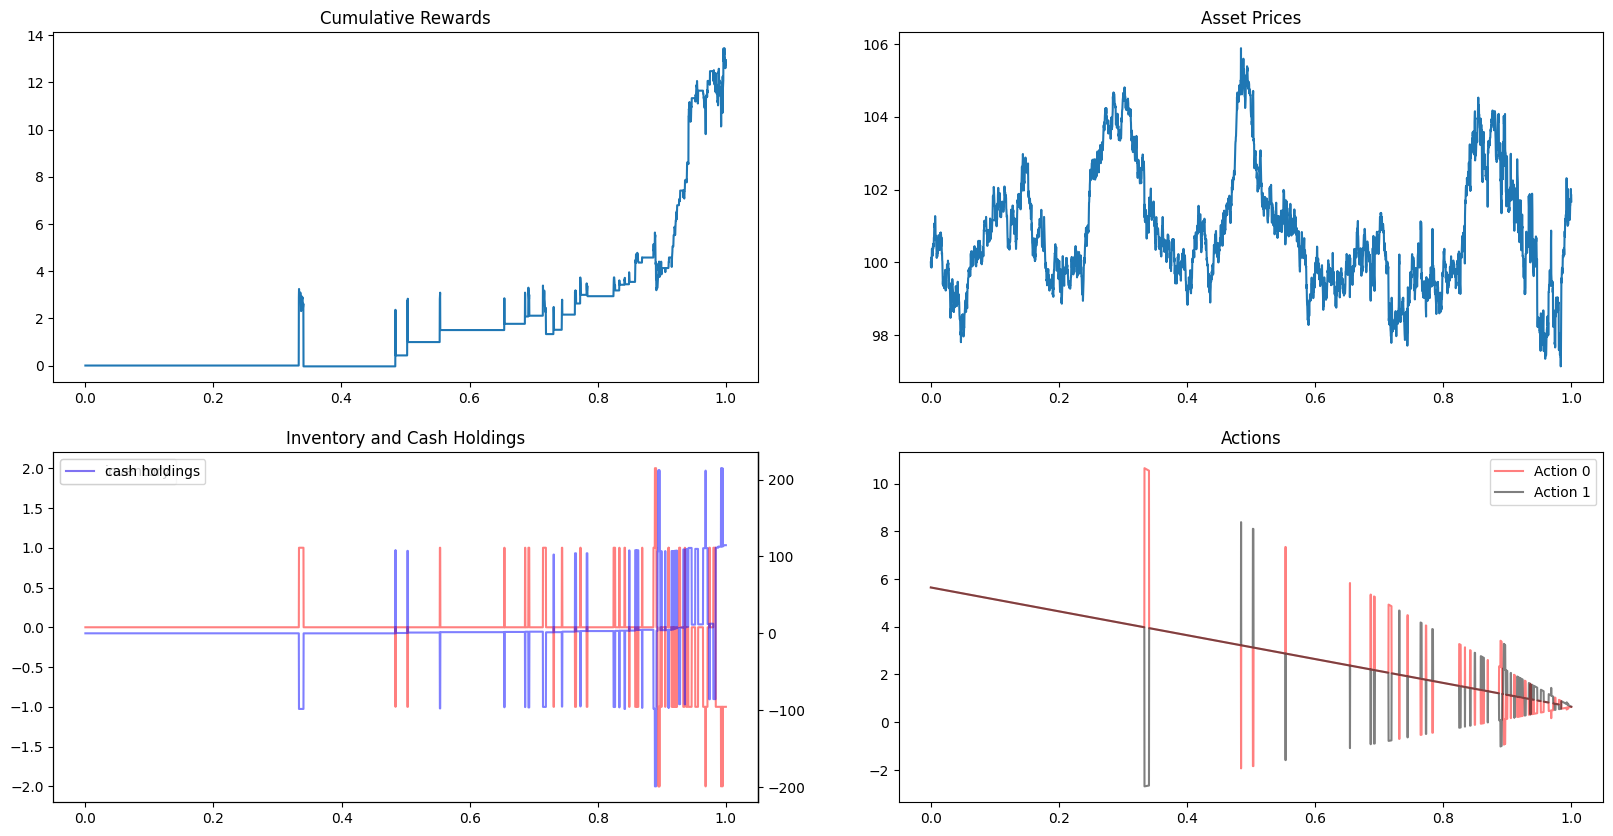

In [15]:
as_env = get_as_env_priceImpact3()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

as_mid_series_7, _ = plot_trajectory(as_env, as_agent, seed = seed)

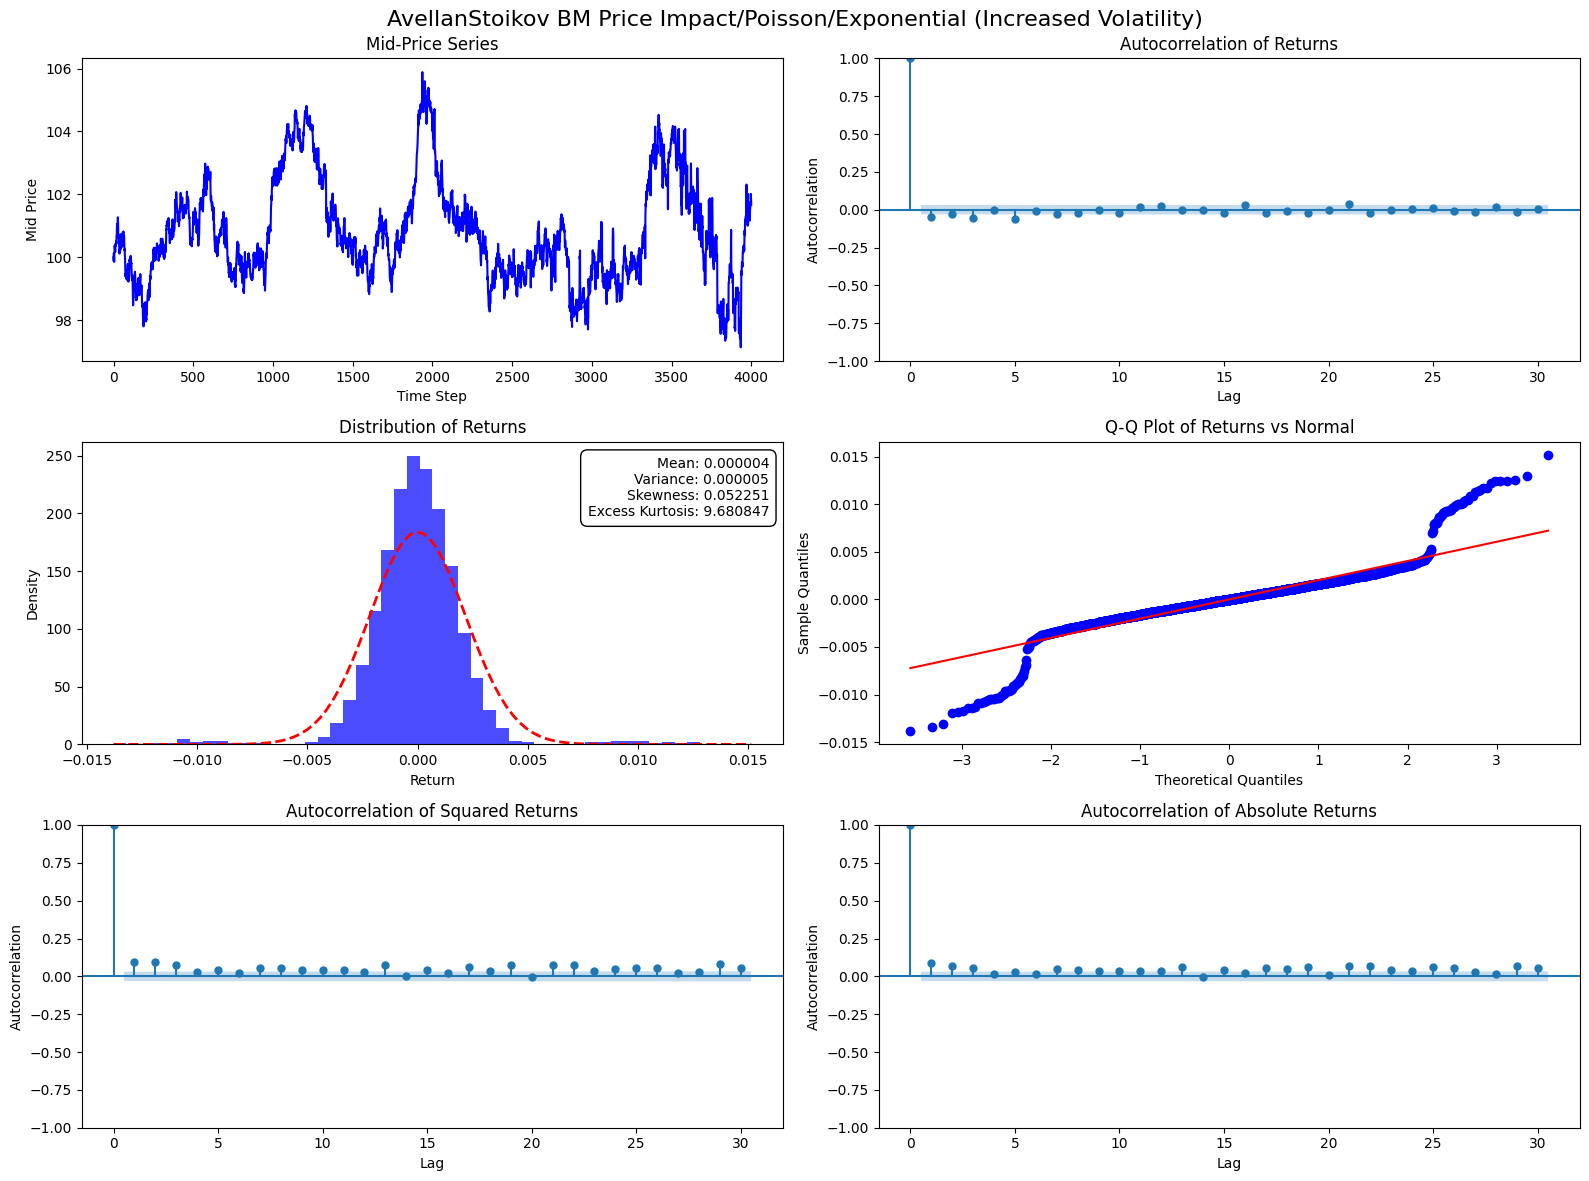

In [16]:
visualize_return(as_mid_series_7, "AvellanStoikov BM Price Impact/Poisson/Exponential (Increased Volatility)")

## My Model

In [17]:
# reset seed here
seed = np.random.randint(0, 10000000)
print("Seed in this run: ", seed)

def get_as_env_myModel(num_trajectories:int = 1):
    initial_price = 100
    terminal_time = 1.0
    n_steps = 4000
    initial_inventory = 0

    long_term_drift = 0.0
    sigma = 0.2 # GBM long-term volatility
    zeta = 0.00214  # mean reversion speed
    eta = 0.02207 # Short-term alpha volatility
    epsilon_plus = 0.000219
    epsilon_minus = -0.000184  # Jump size of sell MOs

    baseline_arrival_rate = 29.16 
    mean_reversion_speed = 140.05
    self_excitation_factor = 64.16
    cross_excitation_factor = 55.73
    # baseline_arrival_rate = -0.7111 # theta
    # mean_reversion_speed = 174.6856 # beta
    # self_excitation_factor = 35.7774 # eta
    # cross_excitation_factor = -1.9835 # nu

    fill_exponent = 1.7348 # Power law fill function exponent
    fill_multiplier = 0.1377 # Power law fill function multiplier

    midprice_model = CustomAlphaMidpriceModel(long_term_drift = long_term_drift, 
        volatility = sigma,
        zeta = zeta, # ζ
        eta = eta, # η
        epsilon_plus = epsilon_plus, # ε^+
        epsilon_minus = epsilon_minus, # ε^-
        initial_price = initial_price,
        terminal_time = terminal_time,
        step_size = 1/n_steps,
        num_trajectories = num_trajectories)
    arrival_model = CustomArrivalModel(baseline_arrival_rate=baseline_arrival_rate,
                                        mean_reversion_speed=mean_reversion_speed,
                                        self_excitation_factor=self_excitation_factor,
                                        cross_excitation_factor=cross_excitation_factor,
                                        step_size=1/n_steps,
                                        terminal_time=terminal_time,
                                        num_trajectories=num_trajectories)
    fill_probability_model = CustomPowerFillFunction(fill_exponent=fill_exponent,
                                                    fill_multiplier=fill_multiplier,
                                                    step_size=1/n_steps,
                                                    num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

Seed in this run:  5924028


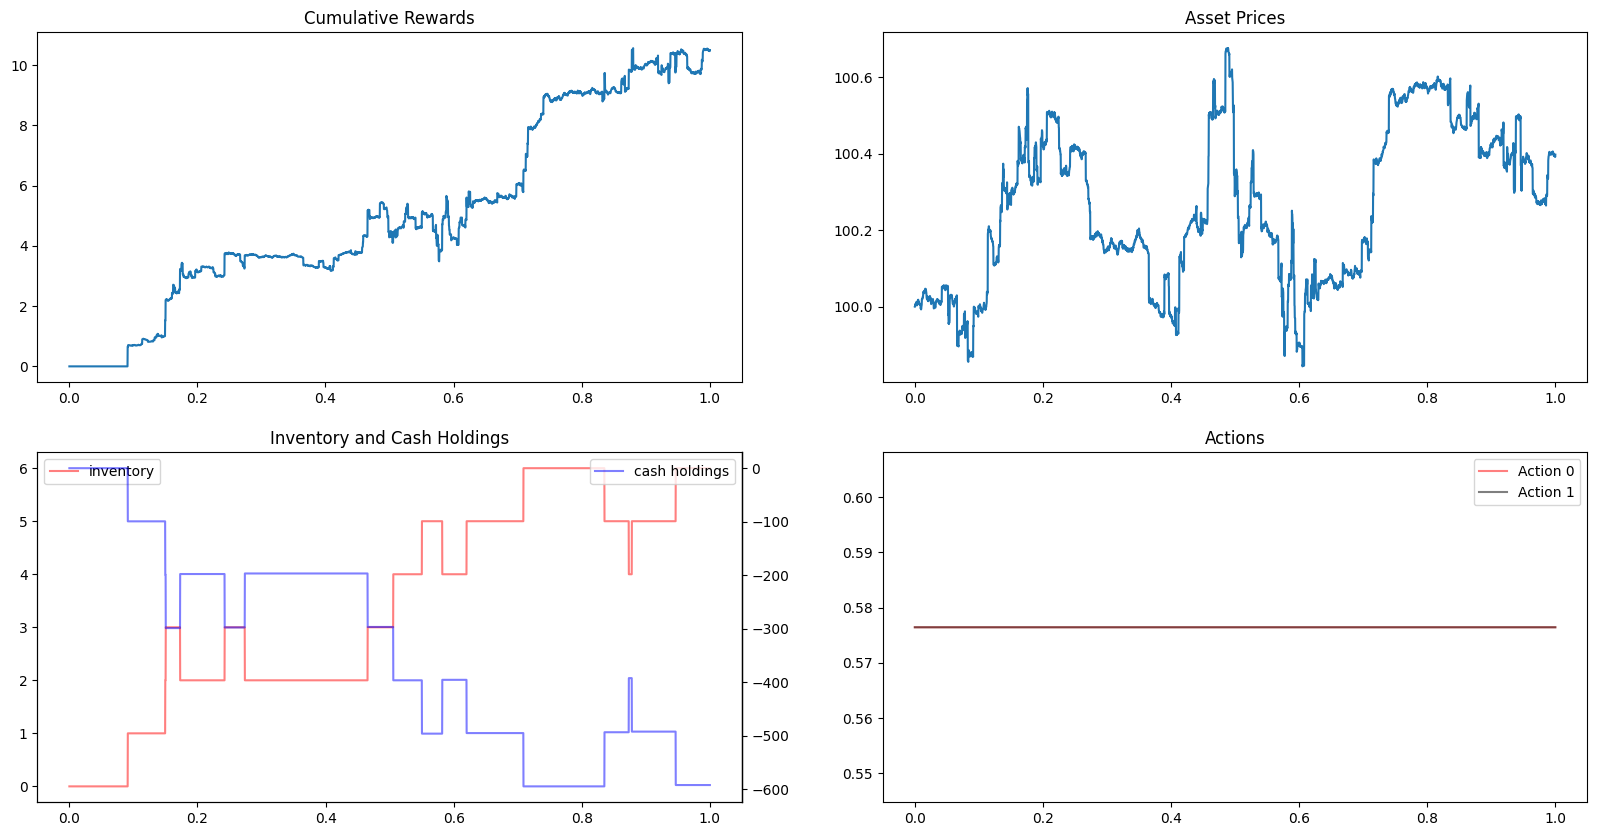

In [18]:
as_env = get_as_env_myModel()
# as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)
as_agent = CarteaJaimungalMmAgent(env=as_env)

as_mid_series_my, _ = plot_trajectory(as_env, as_agent, seed = seed)

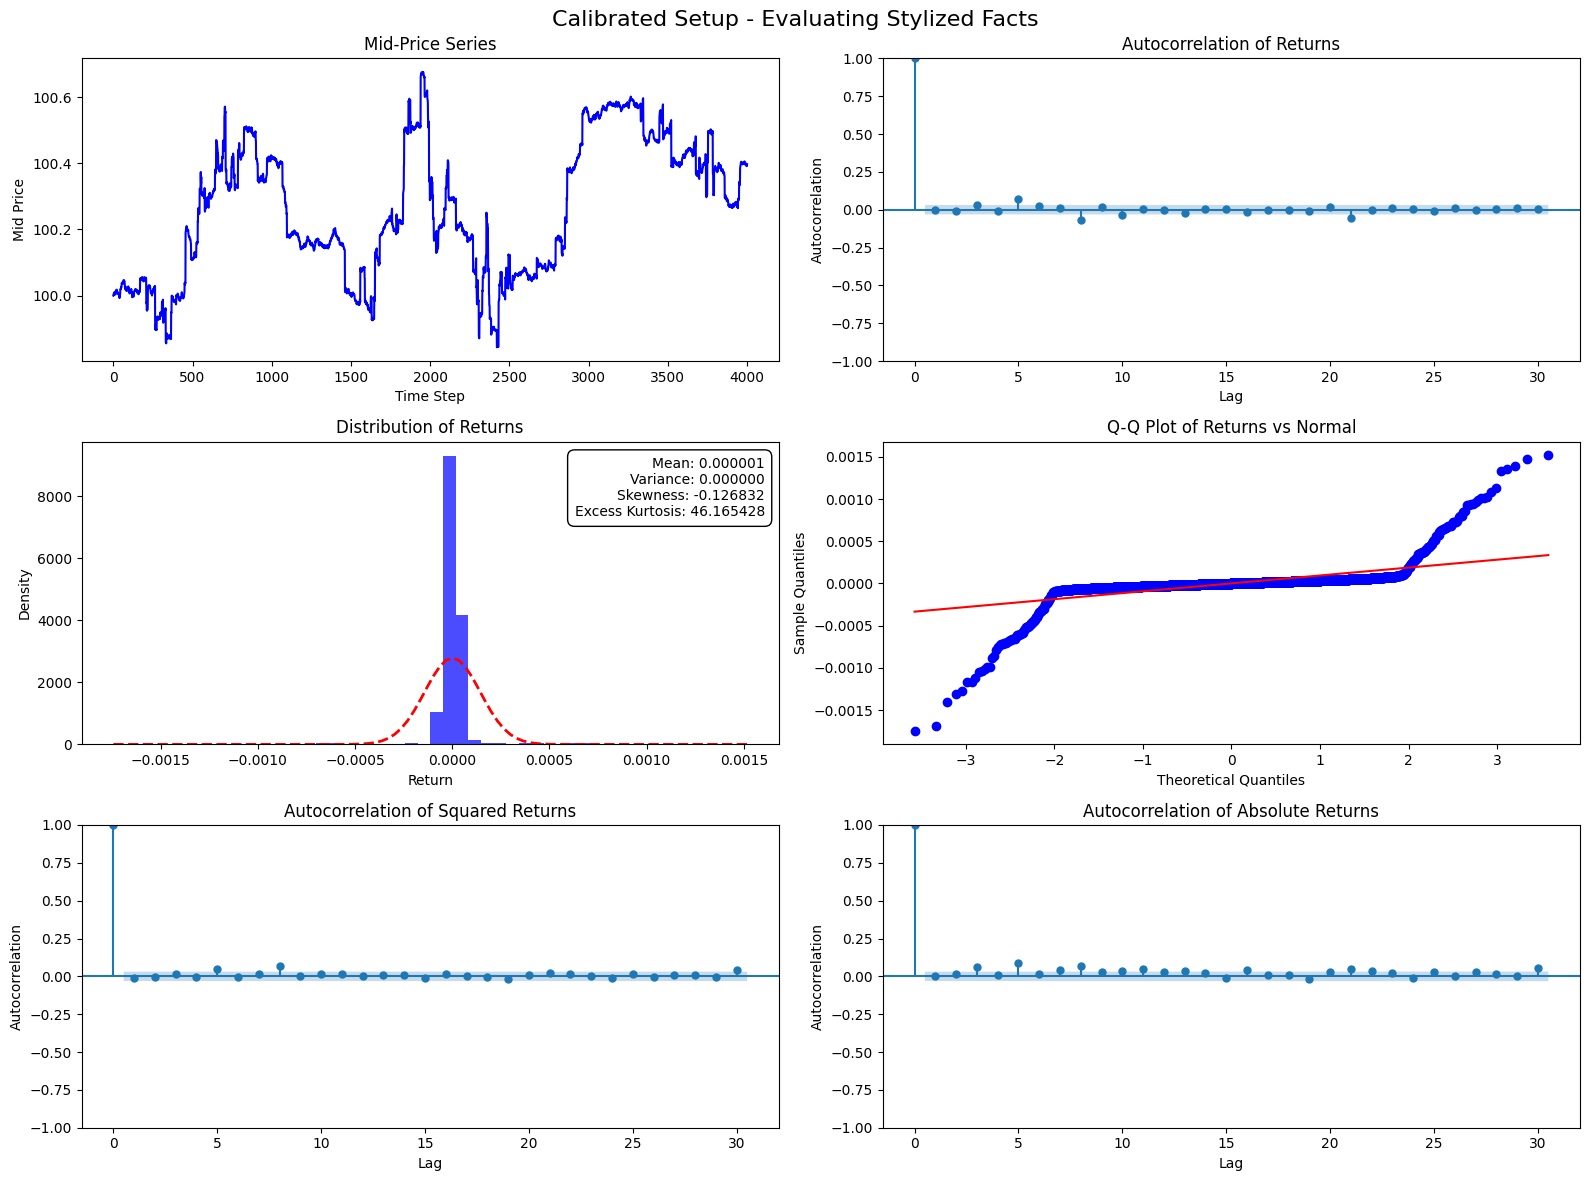

In [19]:
visualize_return(as_mid_series_my, "Calibrated Setup - Evaluating Stylized Facts")